In [14]:
import pandas as pd
import numpy as np
import csv
import openpyxl
import urllib.parse
import requests as req
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import geopandas as gpd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from collections import Counter
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import scale
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import os
from scipy.stats import randint
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

In [17]:
# Data Setup
trainData = pd.read_csv('./dataset/cases_2021_train.csv')
testData = pd.read_csv('./dataset/cases_2021_test.csv')
location = pd.read_csv('./dataset/location_2021.csv')
#https://github.com/samayo/country-json/blob/master/src/country-by-continent.json
countryMap = pd.read_json('./dataset/countryMap.json')


In [18]:
# Globals
fullSet = pd.concat([trainData,testData], ignore_index=True)
fullSet = pd.merge(fullSet, countryMap, on='country', how='left')
countrySet = fullSet.groupby("country")
fullSet = fullSet.groupby("continent")
results = {}
# This is a pre-config for the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#because they are special
world['name'] = world['name'].replace('United States of America', 'United States')

C:\Users\trist\AppData\Local\Temp\ipykernel_40236\1990936332.py:8: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [19]:
# HELPERS

# Helper function, this is what is counting and calculating data that is currently present
def parsePercentages(group):
    counts = {}
    for column in group.columns:
        counts[column] = group[column].count()
    percentages = {field: (count /  len(group)) * 100 for field, count in counts.items()}
    total_percent = sum(percentages.values()) / 11
    return counts, percentages, total_percent

# Helper function to create heat maps, if you want to change something about the heat maps do it here
def createHeatMap(world, column, title, filename):
    fig, ax = plt.subplots()
    world.plot(column=column, cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
    ax.axis('off')
    ax.set_title(title, fontdict={'fontsize': '18', 'fontweight' : '3'})
    plt.show()

In [20]:
# Continent Logic
for country, group in fullSet:
    counts, percentages, total_percent = parsePercentages(group)
    results[country] = {
        "DataSize": len(group), # total data size per country
        "counts":counts, # counts data that exists vs what does not exist
        "percentages":percentages, # calculates percentage of data that is avaialable for each category
        "overall data": total_percent # calculates an overall "percent" of data that is present
    }

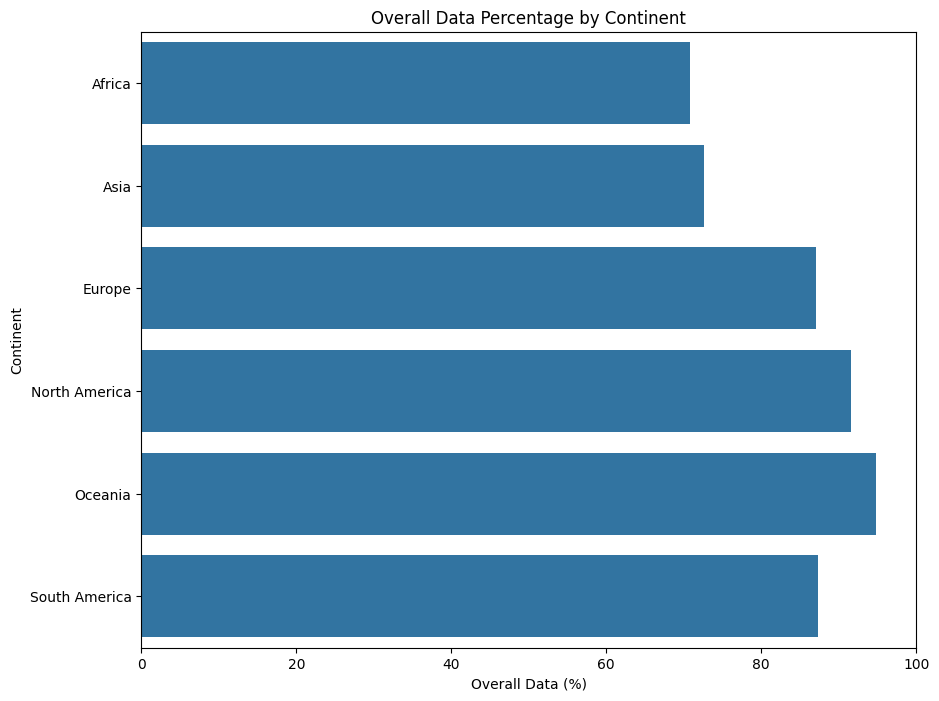

In [28]:
# Convert to data frame to work with data properly, need to use Transpose to set country as col. 
barResults = pd.DataFrame(results).T
#normalize
barResults['overall data'] = barResults['overall data'] - (barResults['overall data'] * 0.1)
# For bar plot of continents
plt.figure(figsize=(10, 8))
sns.barplot(x=barResults['overall data'], y=barResults.index)
plt.xlabel('Overall Data (%)')
plt.xlim(0, 100)
plt.ylabel('Continent')
plt.title('Overall Data Percentage by Continent')
plt.show()

In [22]:
for country, group in countrySet:
    counts, percentages, total_percent = parsePercentages(group)
    country_index = world.index[world['name'] == country].tolist()
    if country_index:
        world.at[country_index[0], 'overallPercent'] = total_percent
        world.at[country_index[0], 'agePercent'] = percentages['age']
        world.at[country_index[0], 'sexPercent'] = percentages['sex']
        world.at[country_index[0], 'outcome'] = percentages['outcome']
# Lots of countries missing, need to fill them with something otherwise they just dont appear on maps
world['overallPercent'].fillna(0, inplace=True)
world['agePercent'].fillna(0, inplace=True)
world['sexPercent'].fillna(0, inplace=True)
world['outcome'].fillna(0, inplace=True)

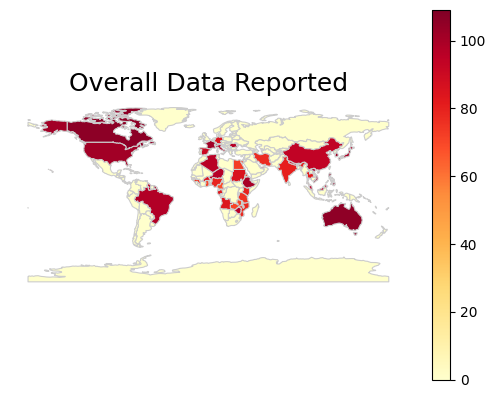

In [23]:
# Heatmaps
createHeatMap(world, 'overallPercent', 'Overall Data Reported', 'Overall.svg')

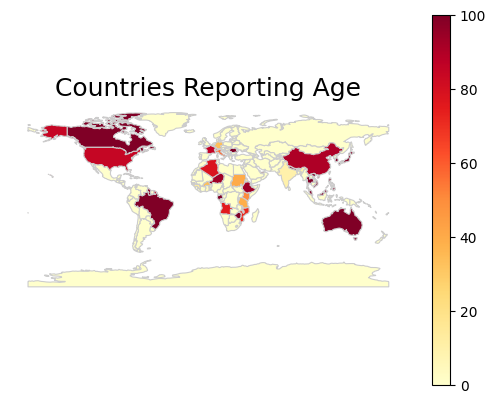

In [24]:
createHeatMap(world, 'agePercent', 'Countries Reporting Age', 'Countries.svg')


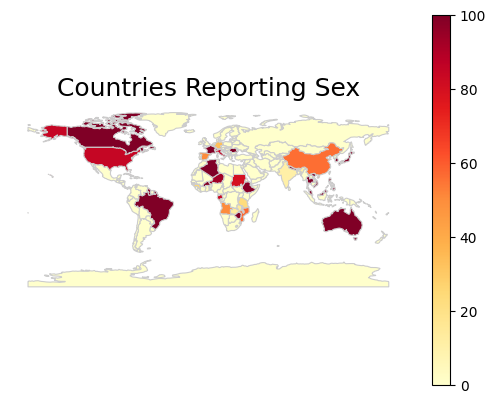

In [25]:
createHeatMap(world, 'sexPercent', 'Countries Reporting Sex', 'Sex.svg')

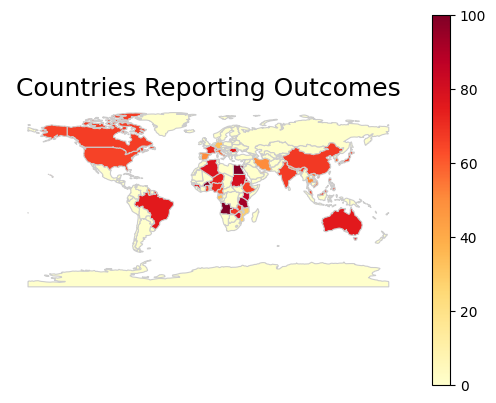

In [26]:
createHeatMap(world, 'outcome', 'Countries Reporting Outcomes', 'Outcome.svg')

In [12]:
# Task 2
# Data Preprocessing Stage - Train Dataset
# dictionary to map invalid countries to valid ones
invalid_countries = {
    'Taiwan*': 'Taiwan',
    'Korea, South': 'South Korea',
    'US': 'United States',
    'Congo (Brazzaville)': 'Democratic Republic of the Congo',
    'Congo (Kinshasa)': 'Democratic Republic of the Congo',
    'MS Zaandam': 'Unknown',
    'West Bank and Gaza': 'Palestine',
    'Summer Olympics 2020': 'Unknown',
    'Holy See': 'Vatican City',
    'Burma': 'Myanmar',
    'Sao Tome and Principe': 'São Tomé and Príncipe',
    'Cabo Verde': 'Cape Verde',
    'Diamond Princess': 'Unknown',
    'Cote d\'Ivoire': 'Ivory Coast',
    '' : 'Unknown',
}

# dictionary to map non uniform outcomes to standard group of three outcome: Hosipitalized, Discharged, Deceased
map_outcome = {
    'Died': 'Deceased',
    'Death': 'Deceased',
    'Discharged from hospital': 'Discharged',
    'released from quarantine': 'Discharged',
    'Discharged': 'Discharged',
    'recovering at home 03.03.2020': 'Discharged',
    'critical condition': 'Hospitalized',
    'Hospitalized': 'Hospitalized',
    'Recovered': 'Discharged',
    'stable condition': 'Hospitalized',
    'Stable condition' : 'Hospitalized',
    'Critical condition' : 'Hospitalized',
    'discharged': 'Discharged',
    'death': 'Deceased',
    'Stable': 'Hospitalized',
    'Dead': 'Deceased',
    'Released from quarantine' : 'Discharged',
    'Deceased': 'Deceased',
    'recovered': 'Discharged',
    'died': 'Deceased',
    'Under treatment': 'Hospitalized',
    'Receiving Treatment': 'Hospitalized',
    'Alive': 'Hospitalized',
    'discharge': 'Discharged',
    'stable': 'Hospitalized',
    'Discharged from hospital': 'Discharged',
    'Discharge' : 'Discharged',
}

# renaming due to conflict of column names in location csv
trainData.rename(columns={'latitude': 'case_lats', 'longitude': 'case_longs'}, inplace=True)

# add the new column for merging later
trainData['Combined_Key'] = ''

# round off the latitude and longitude to 6 decimal places
trainData = trainData.round({'case_lats': 6, 'case_longs': 6})

def process_train_data(dataFrame):
    dataFrame.reset_index(drop=True, inplace=True)
    indices_to_drop = []
    for index, row in dataFrame.iterrows():
        # if the country is invalid, then update it to the correct country
        if row['country'] in invalid_countries:
            dataFrame.at[index, 'country'] = invalid_countries[row['country']]
            
        # if the combined_key doesn't have province info before comma, then remove comma and trim
        if row['Combined_Key'] == '':
            if row['province'] != '':
                dataFrame.at[index, 'Combined_Key'] = str(row['province']) + ', ' + str(row['country'])
            else:
                dataFrame.at[index, 'Combined_Key'] = row['country']
                
        # if the age is a range with a dash, then split the range and take the average
        if row['age'] != '' and type(row['age']) == str and '-' in row['age']:
            age_range = row['age'].split('-')
            # if the dash has only one number before and after, then take the number as the age
            if len(age_range) == 2 and age_range[0].isdigit() and age_range[1].isdigit():
                dataFrame.at[index, 'age'] = (int(age_range[0]) + int(age_range[1])) / 2
            else:
                dataFrame.at[index, 'age'] = int(age_range[0])
        
        if row['province'] == 'Taiwan':
            dataFrame.at[index, 'country'] = 'Taiwan'
            dataFrame.at[index, 'Combined_Key'] = 'Taiwan'
            dataFrame.at[index, 'province'] = ''
        
        dataFrame.at[index, 'outcome_group'] = map_outcome[row['outcome']] if row['outcome'] in map_outcome else row['outcome']
        
        if type(row['outcome']) != str:
            print(f'Outcome is not a string: {row["outcome"]}')
            # print whole row
            print(row)
        else:
            # make outcome all lowercase and first letter uppercase
            dataFrame.at[index, 'outcome'] = row['outcome'].lower().capitalize().strip() if row['outcome'] else 'Unknown'  
                
        # if age or sex is missing, then add to indices_to_drop
        age = row['age']
        sex = row['sex']
        if pd.isna(age) or pd.isna(sex):
            indices_to_drop.append(index)
            
          # if additional data is missing, then update it to Not Available
        if row['additional_information'] == '' or pd.isnull(row['additional_information']):
            dataFrame.at[index, 'additional_information'] = 'Not Available'
            
    dataFrame.drop(list(indices_to_drop), inplace=True, errors='ignore')
    dataFrame.reset_index(drop=True, inplace=True)
    
    return dataFrame

trainData = process_train_data(trainData)

/var/folders/20/6z2m5pp5031593mcfkb5rtc40000gn/T/ipykernel_3596/1609320288.py:91: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Hospitalized' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataFrame.at[index, 'outcome_group'] = map_outcome[row['outcome']] if row['outcome'] in map_outcome else row['outcome']


In [13]:
# Task 2 Continued
# Data Preprocessing Stage - Location Dataset

# cleaning the location data
countries_dict = {}

def get_population_continent(country):
    country = country.strip()
    country = country.lower()
    # make country url safe
    country = urllib.parse.quote(country)

    #call get api on restcountries.com/v3.1/name/{country}?fullText=true
    response = req.get(f'https://restcountries.com/v3.1/name/{country}?fullText=true')
    if response.status_code == 200:
        data = response.json()
        if len(data) > 0:
            return data[0]['population'], data[0]['latlng'][0], data[0]['latlng'][1]
        else:
            return 0
    else:
        return 0
    

def update_countries_population_dict(countries):
    if countries is not None:
        for country in countries:
            if country not in countries_dict:
                if country in invalid_countries:
                    country = invalid_countries[country]
                if country == 'Taiwan':
                    countries_dict[country] = {
                        'population': 23576775,
                        'Lat': 23.6978,
                        'Long_': 120.9605
                    }
                elif country == 'Unknown':
                    continue
                else:
                    country_info = get_population_continent(country)
                    # if country info is of type int
                    if country_info is not None and isinstance(country_info, int):
                        print(f'Country {country} not found')
                    else:
                        countries_dict[country] = {
                            'population': country_info[0] if country_info[0] else 0,
                            'Lat': country_info[1] if country_info[1] else 0,
                            'Long_': country_info[2] if country_info[2] else 0
                        }
                        
        
def process_location_data(dataFrame):
    dataFrame.reset_index(drop=True, inplace=True)
    dataFrame.fillna({'Confirmed': 0, 'Deaths': 0, 'Active': 0, 'Recovered': 0}, inplace=True)
    dataFrame['Expected_Mortality_Rate'] = dataFrame['Deaths'].astype('float') / dataFrame['Confirmed'].astype('float')
    update_countries_population_dict(dataFrame['Country_Region'].unique())
    dataFrame.reset_index(drop=True, inplace=True)
    dataFrame = dataFrame.drop_duplicates(subset=None, keep="first", inplace=False)
    indices_to_drop = []
    for index, row in dataFrame.iterrows():
        country = row['Country_Region']
        province = str(row['Province_State'])
        deaths = recovered = active = confirmed = 0

        # if the country is invalid, then update it to the correct country
        if country in invalid_countries:
            corrected_country = invalid_countries[country]
            dataFrame.at[index, 'Country_Region'] = corrected_country
            if row['Province_State'] != '':
                dataFrame.at[index, 'Combined_Key'] = province + ', ' + corrected_country
            else:
                dataFrame.at[index, 'Combined_Key'] = corrected_country

        # Special case for Taiwan
        if province == 'Taiwan':
            dataFrame.at[index, 'Country_Region'] = 'Taiwan'
            dataFrame.at[index, 'Combined_Key'] = 'Taiwan'
            dataFrame.at[index, 'Province_State'] = ''

        # handle the missing lat and long values
        if row['Lat'] == '' or row['Long_'] == '':
            if country in countries_dict:
                print(f'Country {country} found')
                dataFrame.at[index, 'Lat'] = countries_dict[country]['Lat']
                dataFrame.at[index, 'Long_'] = countries_dict[country]['Long_']   
               
        # if the incident rate is missing, then calculate it based on population and confirmed cases 
        if row['Incident_Rate'] == '' and row['Country_Region'] != 'Unknown':
            count += 1
            if row['Confirmed'] != '' and row['Confirmed'] != '0':
                try:
                    confirmedCases = int(row['Confirmed'])
                    population = countries_dict[row['Country_Region']]['population']
                    dataFrame.at[index, 'Incident_Rate'] = (confirmedCases / population) * 100000
                except ZeroDivisionError:
                    dataFrame.at[index, 'Incident_Rate'] = 0
                except:
                    print('Error calculating incident rate for country: ' + row['Country_Region'] + ' with population: ' + str(population) + ' dic object is: ' + str(countries_dict[row['Country_Region']]));
            else:
                dataFrame.at[index, 'Incident_Rate'] = 0
    
    dataFrame = dataFrame.dropna(subset=['Country_Region'])
    
    return dataFrame

def safe_convert_to_int(value):
    if pd.isnull(value):
        return 0
    try:
        return int(float(value.replace(',', '') if isinstance(value, str) else value))
    except ValueError:
        return 0


def aggregate_repeating_province_country(dataFrame):
    dataFrame.reset_index(drop=True, inplace=True)
    last_key = None
    newEntries = {}
    indices_to_drop = []
    
    for index, row in dataFrame.iterrows():
        current_key = row['Country_Region'] + '_' + str(row['Province_State'])
        
        if current_key == last_key:
            indices_to_drop.extend([index, index - 1])
            
            if last_key in newEntries:
                time1 = datetime.strptime(row['Last_Update'], '%Y-%m-%d %H:%M:%S')
                time2 = datetime.strptime(newEntries[last_key]['Last_Update'], '%Y-%m-%d %H:%M:%S')
                newTime = time1 if time1 > time2 else time2
                newTime = newTime.strftime('%Y-%m-%d %H:%M:%S')

                newEntries[last_key]['Deaths'] += safe_convert_to_int(row['Deaths'])
                newEntries[last_key]['Recovered'] += safe_convert_to_int(row['Recovered'])
                newEntries[last_key]['Active'] += safe_convert_to_int(row['Active'])
                newEntries[last_key]['Confirmed'] += safe_convert_to_int(row['Confirmed'])
                newEntries[last_key]['Incident_Rate'] = newEntries[last_key]['Confirmed'] / countries_dict[row['Country_Region']]['population'] * 100000
                newEntries[last_key]['Case_Fatality_Ratio'] = newEntries[last_key]['Deaths'] / newEntries[last_key]['Confirmed'] * 100 if newEntries[last_key]['Confirmed'] > 0 else 0
                newEntries[last_key]['Expected_Mortality_Rate'] = newEntries[last_key]['Deaths'] / newEntries[last_key]['Confirmed'] if newEntries[last_key]['Confirmed'] > 0 else 0
                newEntries[last_key]['Last_Update'] = newTime
                indices_to_drop.append(index)
            else:
                time1 = datetime.strptime(row['Last_Update'], '%Y-%m-%d %H:%M:%S')
                time2 = datetime.strptime(dataFrame.at[index - 1, 'Last_Update'], '%Y-%m-%d %H:%M:%S')
                newTime = time1 if time1 > time2 else time2
                newTime = newTime.strftime('%Y-%m-%d %H:%M:%S')
                newConfirmed =  safe_convert_to_int(row['Confirmed']) + safe_convert_to_int(dataFrame.at[index - 1, 'Confirmed'])
                newDeaths = safe_convert_to_int(row['Deaths']) + safe_convert_to_int(dataFrame.at[index - 1, 'Deaths'])
                newRecovered = safe_convert_to_int(row['Recovered']) + safe_convert_to_int(dataFrame.at[index - 1, 'Recovered'])
                newActive = safe_convert_to_int(row['Active']) + safe_convert_to_int(dataFrame.at[index - 1, 'Active'])

                try:
                    newIncidentRate = newConfirmed / countries_dict[row['Country_Region']]['population'] * 100000
                except:
                    newIncidentRate = 0
                    
                try:
                    newEntries[last_key] = {
                        'Country_Region': row['Country_Region'],
                        'Province_State': row['Province_State'],
                        'Lat': row['Lat'],
                        'Long_': row['Long_'],
                        'Last_Update': newTime,
                        'Deaths': newDeaths,
                        'Recovered': newRecovered,
                        'Active': newActive,
                        'Combined_Key': row['Combined_Key'],
                        'Confirmed': newConfirmed,
                        'Incident_Rate': newIncidentRate,
                        'Case_Fatality_Ratio': newDeaths / newConfirmed * 100 if newConfirmed > 0 else 0,
                        'Expected_Mortality_Rate': newDeaths / newConfirmed if newConfirmed > 0 else 0
                    }
                except:
                    print('Error creating new entry')
                    
        else:
            if last_key in newEntries and index - 1 not in indices_to_drop:
                indices_to_drop.append(index - 1)
        
        last_key = current_key
        
    dataFrame.drop(indices_to_drop, inplace=True, errors='ignore')
    
    dataFrame.reset_index(drop=True, inplace=True)
    
    newEntries = pd.DataFrame(list(newEntries.values()))
    dataFrame = pd.concat([dataFrame, newEntries], ignore_index=True)
    return dataFrame
    
location = process_location_data(location)
location = aggregate_repeating_province_country(location)
location = location.round({'Expected_Mortality_Rate': 6, 'Case_Fatality_Ratio': 6, 'Incident_Rate': 6})

# Merging the clean datasets
merged_df = pd.merge(trainData, location, on='Combined_Key', how='inner')
merged_df = merged_df.drop(columns = ['Country_Region', 'Province_State', 'Combined_Key', 'outcome' ])
merged_df = merged_df.to_csv('./dataset/task2_preprocessed_data.csv', index=False)

In [14]:
# EXCEL - DF CSV CONVERSION


trainfile = pd.read_excel ('dataset/cases_2021_train_processed_2.xlsx') 
testfile = pd.read_excel ('dataset/cases_2021_test_processed_unlabelled_2.xlsx') 
# Write the dataframe object into csv file 
trainfile.to_csv ('dataset/Train.csv',  
                  index = None, 
                  header=True)
testfile.to_csv ('dataset/Test.csv',  
                  index = None, 
                  header=True) 

In [15]:
# TASK 4: FEATURE MAPPING AND SAVE MAPPED SET

# read csv file and convert into a dataframe object 
trainData = pd.DataFrame(pd.read_csv('dataset/Train.csv')) 
testData = pd.DataFrame(pd.read_csv('dataset/Test.csv'))


def mapProvinceCountries(trainData, testData):
    # Creating unique combinations of province and country in both datasets
    train_combinations = trainData[['province', 'country']].drop_duplicates()
    test_combinations = testData[['province', 'country']].drop_duplicates()
    
    # Combining the two sets of combinations and removing duplicates
    all_combinations = pd.concat([train_combinations, test_combinations]).drop_duplicates()

    # Creating a unique mapping for each province-country combination
    province_country_mapping = {f"{row.province}-{row.country}": idx for idx, row in enumerate(all_combinations.itertuples(), 1)}
    
    # Creating a unique mapping for countries
    allCountries = np.concatenate((trainData['country'].unique(), testData['country'].unique()))
    allCountries = np.unique(allCountries)
    country_mapping = {country: idx for idx, country in enumerate(allCountries, 1)}
    
    return province_country_mapping, country_mapping

province_mapping, country_mapping = mapProvinceCountries(trainData, testData)

print("Province Mapping Example:", list(province_mapping.items())[:5])
print("Country Mapping Example:", list(country_mapping.items())[:5])
    
# map function
def mapFeatures(df, province_mapping=province_mapping, country_mapping=country_mapping):
    # Map 'sex' to binary values
    sex_mapping = {"male": 0, "female": 1}
    df["sex"] = df["sex"].map(sex_mapping)

    # Map 'province' to numbers from 0
    df['province'] = df.apply(lambda row: province_mapping.get(f"{row['province']}-{row['country']}", np.nan), axis=1)
    # Replace the country names with their corresponding numeric codes
    df['country'] = df['country'].map(country_mapping)
    
    # Map chronic disease
    cdb_mapping = {False: 0, True: 1}
    df['chronic_disease_binary'] = df['chronic_disease_binary'].map(cdb_mapping)

mapFeatures(trainData)
mapFeatures(testData)

# Map outcome group for train data
og_mapping = {"deceased": 0,"hospitalized": 1,"nonhospitalized":2}
trainData['outcome_group'] = trainData['outcome_group'].map(og_mapping)

#print(trainData.head(10))
# Save as csv files
trainData.to_csv ('dataset/Mapped_Train.csv',  
                  index = None, 
                  header=True)
testData.to_csv ('dataset/Mapped_Test.csv',  
                  index = None, 
                  header=True) 

Province Mapping Example: [('Bihar-India', 1), ('nan-Philippines', 2), ('Tamil Nadu-India', 3), ('Maharashtra-India', 4), ('Odisha-India', 5)]
Country Mapping Example: [('Algeria', 1), ('Angola', 2), ('Australia', 3), ('Bahamas', 4), ('Brazil', 5)]


In [16]:
# TASK 5
directory_name = "plots"
if not os.path.exists(directory_name):
    os.makedirs(directory_name)
for column in trainData:
    name = "".join(column)
    plot = sns.histplot(data=trainData, x=name)
    fig = plot.get_figure()
    fig.suptitle(name)
    str1 = "./plots/" 
    str2 = ".png"
    name = "".join((str1, name, str2))
    fig.savefig(name)
    fig.clear()

<Figure size 640x480 with 0 Axes>

In [17]:
print("Missing/NULL values in train data set:")
print(trainData.isna().sum())
data_missVal = np.array(trainData.isna().sum())

Missing/NULL values in train data set:
age                       0
sex                       0
province                  0
country                   0
latitude                  0
longitude                 0
date_confirmation         0
chronic_disease_binary    0
Confirmed                 0
Deaths                    0
Recovered                 0
Active                    0
Incident_Rate             0
Case_Fatality_Ratio       0
outcome_group             0
dtype: int64


In [18]:
#OVERSAMPLING MINORITY CLASSES
# print('column #', '\tcolumn name', '\t\t\tcolumn dataType')
k_num = np.arange(0, 15, 1)
data_types = []
k = 0
for column in trainData:
#     print(data_train[column].value_counts())
    data_types.append(type(trainData[column][0]))
#     print('\t', k, '\t', column, '\t\t', type(trainData[column][0]))
    k += 1
cols = list(trainData.columns.values)
d = {'column name': cols, 'column types': data_types, 'NULL count': data_missVal}
data_info = pd.DataFrame(data = d)
data_info

,column name,column types,NULL count
0,age,<class 'numpy.int64'>,0
1,sex,<class 'numpy.int64'>,0
2,province,<class 'numpy.int64'>,0
3,country,<class 'numpy.int64'>,0
4,latitude,<class 'numpy.float64'>,0
5,longitude,<class 'numpy.float64'>,0
6,date_confirmation,<class 'str'>,0
7,chronic_disease_binary,<class 'numpy.int64'>,0
8,Confirmed,<class 'numpy.int64'>,0
9,Deaths,<class 'numpy.int64'>,0


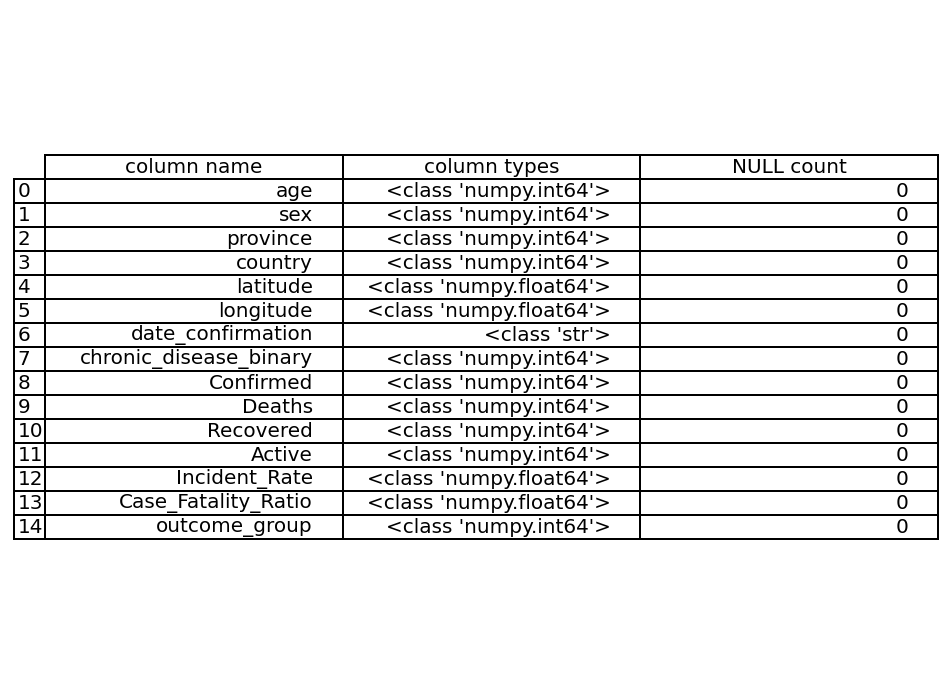

In [19]:
from pandas.plotting import table

fig = plt.figure(figsize=(8,6), dpi=144)
ax = fig.add_subplot(111, frame_on=False) 
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

table(ax, data_info, loc='center')  # where df is your data frame

plt.savefig('./plots/info_table.png')

In [20]:
def ratiosClasses(df):
    print(df.shape)
    sexCount = Counter(df["sex"])
    outGroupCount = Counter(df["outcome_group"])
    CDBCount = Counter(df["chronic_disease_binary"])

    print("\ncolumn 'sex':")
    total = sum(sexCount.values())
    for face, count in sexCount.most_common():
        print(f"{face}: {count} ({count/total:.2%})")

    print("\ncolumn 'outcome_group':")
    total = sum(outGroupCount.values())
    for face, count in outGroupCount.most_common():
        print(f"{face}: {count} ({count/total:.2%})")

    print("\ncolumn 'chronic_disease_binary':")
    total = sum(CDBCount.values())
    for face, count in CDBCount.most_common():
        print(f"{face}: {count} ({count/total:.2%})")
ratiosClasses(trainData)

(17212, 15)

column 'sex':
0: 10799 (62.74%)
1: 6413 (37.26%)

column 'outcome_group':
1: 13241 (76.93%)
2: 2974 (17.28%)
0: 997 (5.79%)

column 'chronic_disease_binary':
0: 17131 (99.53%)
1: 81 (0.47%)


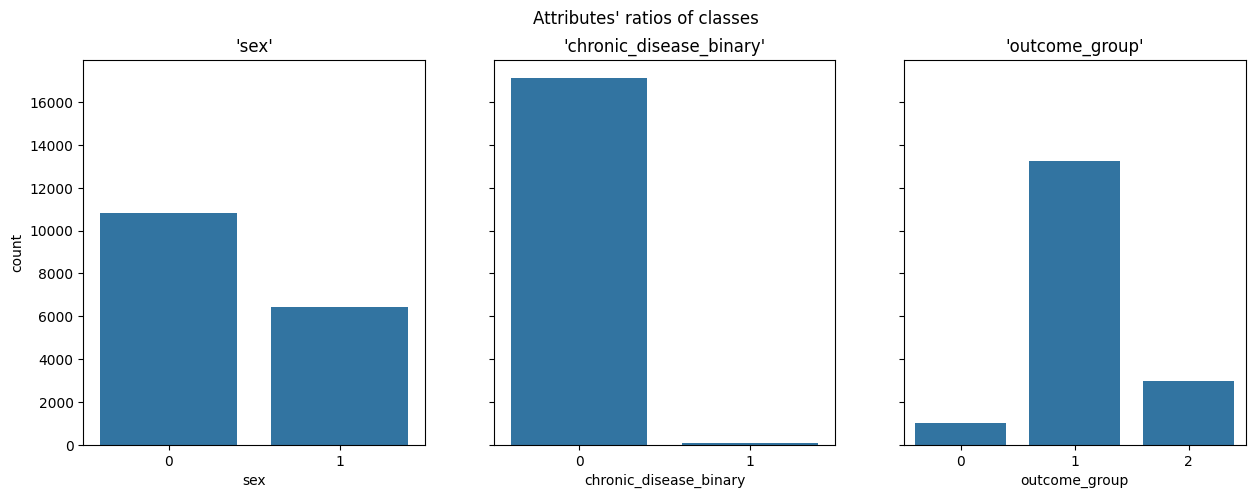

In [21]:
def plotClassDistributions(df, step):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    # sns.barplot(ax=axes[0], x=trainData["sex"], y=trainData.index)
    sns.countplot(data=df, x='sex', ax=axes[0])
    axes[0].set_title("'sex'")
    # sns.barplot(ax=axes[1], x=trainData["chronic_disease_binary"], y=trainData.index)
    sns.countplot(data=df, x='chronic_disease_binary', ax=axes[1])
    axes[1].set_title("'chronic_disease_binary'")
    # sns.barplot(ax=axes[2], x=trainData["outcome_group"], y=trainData.index)
    sns.countplot(data=df, x='outcome_group', ax=axes[2])
    axes[2].set_title("'outcome_group'")
    fig.suptitle("Attributes' ratios of classes")
    if(step == 'None'):
        fig.savefig('./plots/classes_BeforeOversampling.png')
    if(step == 'sex'):
        fig.savefig('./plots/classes_AfterSex.png')
    if(step == 'chronic_disease_binary'):
        fig.savefig('./plots/classes_AfterCDB.png')
    if(step == 'outcome_group'):
        fig.savefig('./plots/classes_AfterOG.png')
plotClassDistributions(trainData, 'None')

new data shape is  (21598, 15)


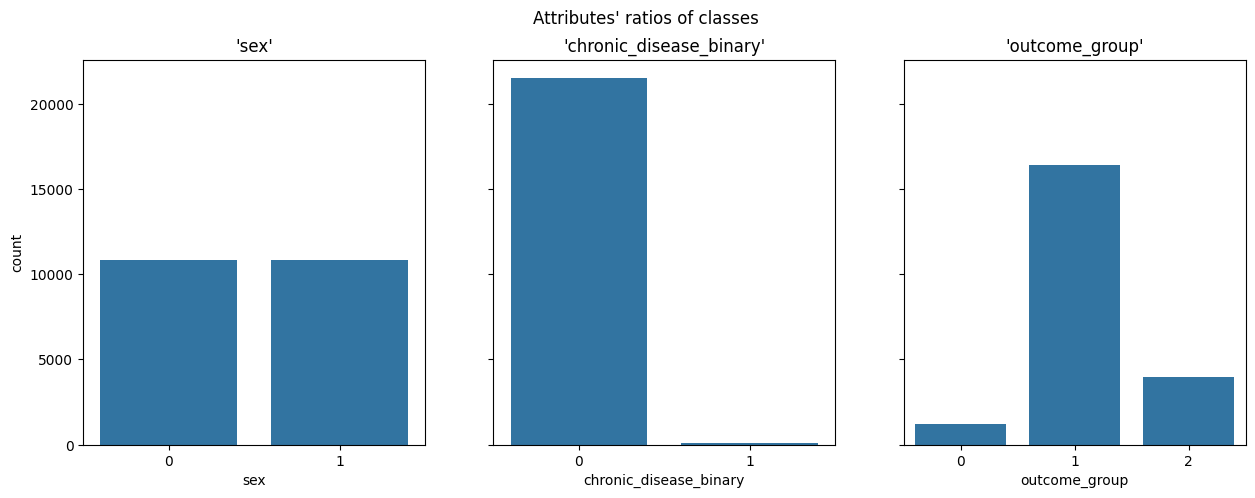

In [22]:
sm = SMOTENC(random_state=42, categorical_features=[1, 2, 3, 5, 6, 13])
newData, newSubData = sm.fit_resample(trainData.drop(columns=["sex"]), trainData["sex"])
newData["sex"] = newSubData
print("new data shape is ", newData.shape)
plotClassDistributions(newData, 'sex')

new data shape is  (43020, 15)


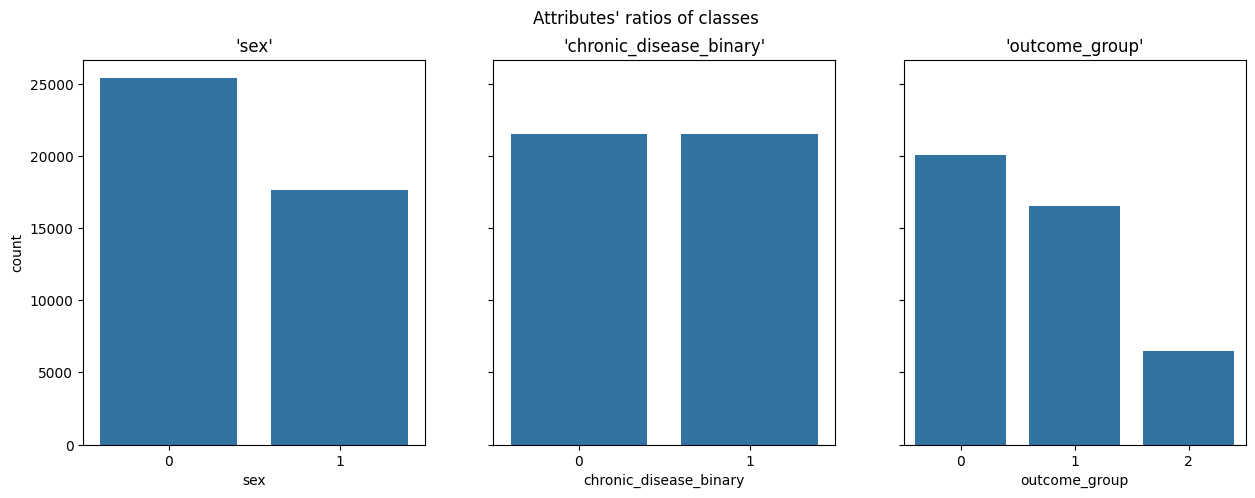

In [23]:
sm = SMOTENC(random_state=42, categorical_features=[1, 2, 5, 12, 13])
newData, newSubData = sm.fit_resample(newData.drop(columns=["chronic_disease_binary"]), newData["chronic_disease_binary"])
newData["chronic_disease_binary"] = newSubData
print("new data shape is ", newData.shape)
plotClassDistributions(newData, 'chronic_disease_binary')

new data shape is  (60096, 15)


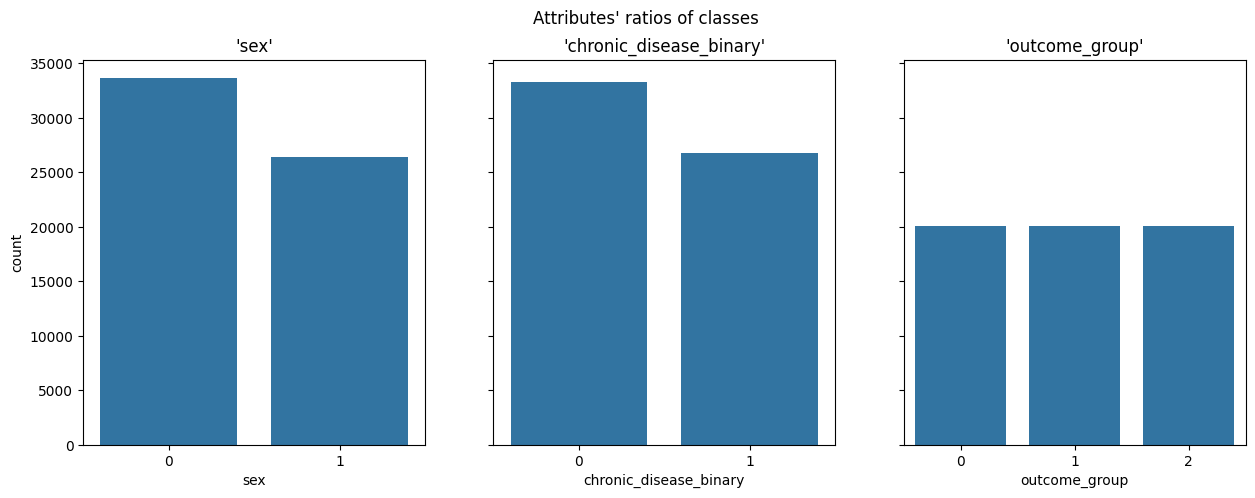

In [24]:
sm = SMOTENC(random_state=42, categorical_features=[1, 2, 5, 12, 13])
newData, newSubData = sm.fit_resample(newData.drop(columns=["outcome_group"]), newData["outcome_group"])
newData["outcome_group"] = newSubData
print("new data shape is ", newData.shape)
plotClassDistributions(newData,'outcome_group')

In [25]:
ratiosClasses(newData)

(60096, 15)

column 'sex':
0: 33671 (56.03%)
1: 26425 (43.97%)

column 'outcome_group':
1: 20032 (33.33%)
2: 20032 (33.33%)
0: 20032 (33.33%)

column 'chronic_disease_binary':
0: 33319 (55.44%)
1: 26777 (44.56%)


In [26]:
cols = list(trainData.columns.values)
newData = newData[cols]

In [27]:
# TASK 6: CLASSIFIERS ON TRAIN SET
# Drop date
data = newData.drop('date_confirmation',axis=1)
# newData = newData.drop('date_confirmation',axis=1)
X = data.drop('outcome_group', axis=1)
y = data['outcome_group']
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [28]:
# Logistics regression classifier

# Preprocess the data for LR only
pdata = data.drop('outcome_group', axis=1)
X1 = scale(pdata)
y1 = data['outcome_group']
# Splitting 
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.4, random_state=42)

# Hyperparameter tuning
# Create pipeline with preprocessing and logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression())
])

# Define hyperparameters for grid search
param_grid = {
    'classifier' : [LogisticRegression()],
    'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']
}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=True, n_jobs=-1)

# Fit grid search to the training data
grid_search.fit(X_train1, y_train1)

# Print best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search.best_params_)
print("Best mean cross-validated score:", grid_search.best_score_)
# Predict
logistic_reg_classifier = LogisticRegression(penalty= grid_search.best_params_['classifier__penalty'], C= grid_search.best_params_['classifier__C'], solver=grid_search.best_params_['classifier__solver'])
logistic_reg_classifier.fit(X_train1, y_train1)
y_pred1 = logistic_reg_classifier.predict(X_test1)
log_pred = logistic_reg_classifier.predict(X_test1)

LR_y_test = y_test1
LR_y_pred = y_pred1
# Evaluate accuracy
accuracy = accuracy_score(y_test1, y_pred1)
print("Accuracy of logistics regression with tuning:", accuracy)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best hyperparameters: {'classifier': LogisticRegression(), 'classifier__C': 0.0018329807108324356, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best mean cross-validated score: 0.8530666728488858
Accuracy of logistics regression with tuning: 0.8548078522708368


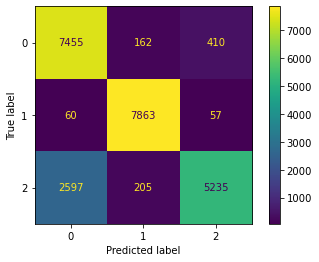

In [29]:
disp = ConfusionMatrixDisplay.from_predictions(LR_y_test, LR_y_pred)
plt.savefig('./plots/confusionMatrix_LR.png')

In [30]:
#Random forest classifier
param_dist = {
    'n_estimators': randint(50, 300), 
    'max_depth': [None] + list(randint(5, 50).rvs(10)),
    'min_samples_split': randint(2, 20), 
    'min_samples_leaf': randint(1, 20)  
}

random_forest = RandomForestClassifier()
random_search = RandomizedSearchCV(estimator=random_forest, param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy', random_state=42)
random_search.fit(X_train, y_train)
# Best parameters found
best_params = random_search.best_params_
print("Best Parameters:", best_params)
# Retrain the model with the best parameters
best_random_forest = RandomForestClassifier(**best_params)
best_random_forest.fit(X_train, y_train)
# Predict on the test set
y_pred = best_random_forest.predict(X_test)
rf_pred = best_random_forest.predict(X_test)

RF_y_test = y_test
RF_y_pred = y_pred
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy after Hyperparameter Tuning: {accuracy}")

Best Parameters: {'max_depth': 25, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 253}
Random Forest Accuracy after Hyperparameter Tuning: 0.9712194310430877


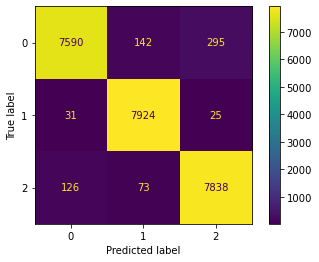

In [31]:
disp = ConfusionMatrixDisplay.from_predictions(RF_y_test, RF_y_pred)
plt.savefig('./plots/confusionMatrix_RF.png')

In [32]:
#K-Nearest Neighbors classifier - Dmitrii Beliaev - dba56@sfu.ca

#hyper parameter tuning
kf=KFold(n_splits = 5, shuffle = True, random_state = 42)
parameter = {'n_neighbors': np.arange(2, 30, 1)}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid=parameter, cv=kf, verbose=1)
knn_cv.fit(X_train, y_train)
print("Best parameters:", knn_cv.best_params_)
print("Best cross-validation score:", knn_cv.best_score_)

knn_classifier = KNeighborsClassifier(n_neighbors=knn_cv.best_params_['n_neighbors'])
knn_classifier.fit(X_train, y_train)
y_pred = knn_classifier.predict(X_test)
knn_pred = knn_classifier.predict(X_test)

KNN_y_test = y_test
KNN_y_pred = y_pred
# Evaluate model accuracy
accuracy = accuracy_score(y_test, y_pred)
print("After parameter tuning\nAccuracy of KNN model:", accuracy)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Best parameters: {'n_neighbors': 3}
Best cross-validation score: 0.9357254176631074
After parameter tuning
Accuracy of KNN model: 0.9412743303942771


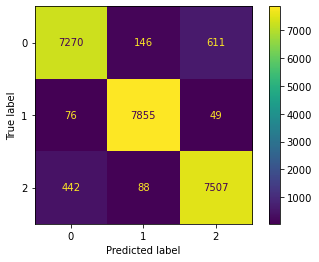

In [33]:
disp = ConfusionMatrixDisplay.from_predictions(KNN_y_test, KNN_y_pred)
plt.savefig('./plots/confusionMatrix_KNN.png')

In [30]:
# Gradient Boosting Classifier - Manvir Heer - msh16@sfu.ca

# Define a set of parameters to test
parameter_grid = {
    'n_estimators': [500, 1000],
    'max_depth': [3, 5, 10, 20, 35],
    'learning_rate': [0.1, 0.4],
    'subsample': [0.8, 0.9]
}

# Initialize the model
gradientBoostingClassifier = GradientBoostingClassifier(random_state=10, loss='log_loss')

# Setup cross-validation method
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=gradientBoostingClassifier, param_grid=parameter_grid, cv=kf, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Results
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

y_pred = grid_search.predict(X_test)
grid_pred = y_pred
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of Gradient Boosting Classifier:", accuracy)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


In [35]:
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.savefig('./plots/confusionMatrix_GB.png')

In [36]:
# CROSS-VALIDATOIN SCORES
#Logistic Regression model
scores = cross_val_score(logistic_reg_classifier, X_train1, y_train1, cv=5, scoring='f1_macro')
print("5-fold cross-validation score for LR: ", scores)
#Random forest model
scores = cross_val_score(best_random_forest, X_train, y_train, cv=5, scoring='f1_macro')
print("5-fold cross-validation score for RF: ", scores)
#K-Nearest Neighbors model
scores = cross_val_score(knn_classifier, X_train, y_train, cv=5, scoring='f1_macro')
print("5-fold cross-validation score for KNN: ", scores)
#Gradient Boosting model
scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, scoring='f1_macro')
print("5-fold cross-validation score for GB: ", scores)

5-fold cross-validation score for LR:  [0.85065961 0.84588574 0.85279263 0.8511334  0.84494556]
5-fold cross-validation score for RF:  [0.9698379  0.96940474 0.97232076 0.9674478  0.96964709]
5-fold cross-validation score for KNN:  [0.93157086 0.93644315 0.93740185 0.93345246 0.93614105]
5-fold cross-validation score for GB:  [0.96175236 0.96062166 0.96203664 0.95841312 0.96382414]


In [37]:
train_accuracies= []
test_accuracies = []
classifiers =[]

In [38]:
# Test all classifier on original set
def OF_check(model,label):
    classifiers.append(label)
    y_pred = model.predict(X_train)
    print(f"Accuracy of {label} with train set is :", accuracy_score(y_train, y_pred))
    train_accuracies.append(accuracy_score(y_train, y_pred))
    y_pred = model.predict(X_test)
    print(f"Accuracy of {label} with validation set is :", accuracy_score(y_test, y_pred))
    test_accuracies.append(accuracy_score(y_test, y_pred))
    

In [39]:
OF_check(best_random_forest,'Random forest model')
OF_check(knn_classifier,'K-Nearest Neighbors model')
OF_check(grid_search.best_estimator_,'Gradient Boosting model')
classifiers.append("Logistic Regression")
y_pred = logistic_reg_classifier.predict(X_train1)
print(f"Accuracy of Logistic Regression modelwith train set is :", accuracy_score(y_train1, y_pred))
train_accuracies.append(accuracy_score(y_train1, y_pred))
y_pred = logistic_reg_classifier.predict(X_test1)
print(f"Accuracy of Logistic Regression model with validation set is :", accuracy_score(y_test1, y_pred))
test_accuracies.append(accuracy_score(y_test1, y_pred))

Accuracy of Random forest model with train set is : 0.9849434338952973
Accuracy of Random forest model with validation set is : 0.9712194310430877
Accuracy of K-Nearest Neighbors model with train set is : 0.9654503105590062
Accuracy of K-Nearest Neighbors model with validation set is : 0.9412743303942771
Accuracy of Gradient Boosting model with train set is : 0.9761257763975155
Accuracy of Gradient Boosting model with validation set is : 0.975960738645816
Accuracy of Logistic Regression modelwith train set is : 0.854342280390417
Accuracy of Logistic Regression model with validation set is : 0.8548078522708368


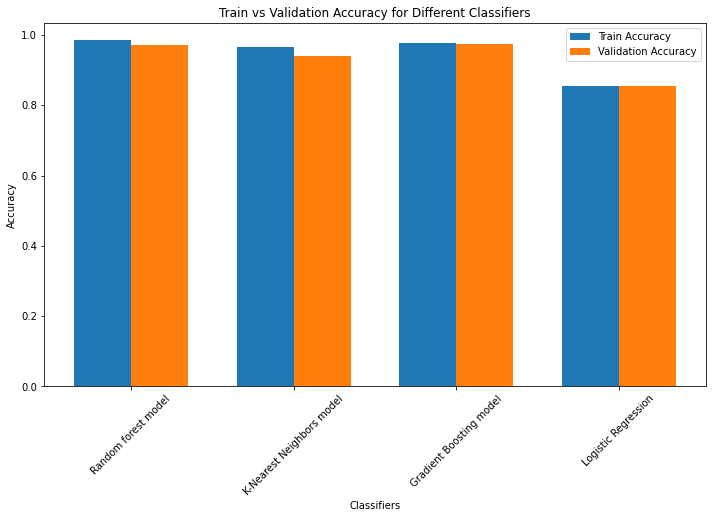

In [40]:
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
train_positions = range(len(classifiers))
test_positions = [x + bar_width for x in train_positions]
ax.bar(train_positions, train_accuracies, bar_width, label='Train Accuracy')
ax.bar(test_positions, test_accuracies, bar_width, label='Validation Accuracy')
ax.set_xlabel('Classifiers')
ax.set_ylabel('Accuracy')
ax.set_title('Train vs Validation Accuracy for Different Classifiers')
ax.set_xticks([p + bar_width / 2 for p in train_positions])
ax.set_xticklabels(classifiers)
ax.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.savefig('./plots/Train_vs_Validation_Accuracy.png')

In [41]:
submission_dir = "submissions"
if not os.path.exists(submission_dir):
    os.makedirs(submission_dir)

def create_submission_file(y_preds, file_name):
    with open(file_name, "w", newline='') as csvfile:
        wr = csv.writer(csvfile)
        wr.writerow(["Id", "Prediction"])
        for i, pred in enumerate(y_preds):
            wr.writerow([str(i), str(pred)])

In [42]:
create_submission_file(log_pred ,"./submissions/logistic_regression.csv")
create_submission_file(rf_pred, "./submissions/random_forest.csv")
create_submission_file(knn_pred, "./submissions/k_nearest_neighbors.csv")
create_submission_file(grid_pred, "./submissions/gradient_boosting_classifier.csv")